In [3]:
from source.MI import MI
from source.datalib import *
from source.gradient_ssim import MultiModalAlignmentMetric
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter, laplace
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
from torch import nn
from torch.functional import F
import torch.optim.lr_scheduler as lr_scheduler

wavelength_to_index = lambda x, wavelengths: np.argmin( np.abs( wavelengths - x ) )

In [286]:
# class AffineTransform(nn.Module):
#     def __init__(self, scale=1., transX=0., transY=0., angle=0., device='cpu'):
#         super().__init__()
#         self.scale = nn.Parameter(torch.tensor(scale, dtype=torch.float, device=device))
#         self.transX = nn.Parameter(torch.tensor(transX, dtype=torch.float, device=device))
#         self.transY = nn.Parameter(torch.tensor(transY, dtype=torch.float, device=device))
#         self.angle = nn.Parameter(torch.tensor(angle, dtype=torch.float, device=device))
#         self.device = device

#     def get_theta(self, input_size):
#         cos_angle = torch.cos(self.angle)
#         sin_angle = torch.sin(self.angle)
        
#         h, w = input_size[2], input_size[3]
#         aspect_ratio = w / h
        
#         rotation_matrix = torch.stack([
#             torch.cat([cos_angle.unsqueeze(0), (-sin_angle).unsqueeze(0)]),
#             torch.cat([sin_angle.unsqueeze(0), cos_angle.unsqueeze(0)])
#         ])
        
#         scaling_matrix = torch.tensor([[aspect_ratio, 0], [0, 1]], device=self.device)
#         transform_matrix = rotation_matrix @ scaling_matrix
#         transform_matrix = transform_matrix / torch.sqrt(torch.det(transform_matrix))
#         transform_matrix = self.scale * transform_matrix
#         return torch.stack([
#             torch.cat([transform_matrix[0, 0].unsqueeze(0), transform_matrix[0, 1].unsqueeze(0), self.transX.unsqueeze(0)]),
#             torch.cat([transform_matrix[1, 0].unsqueeze(0), transform_matrix[1, 1].unsqueeze(0), self.transY.unsqueeze(0)])
#         ]).unsqueeze(0)

#     def forward(self, x):
#         theta = self.get_theta(x.size())
#         grid = F.affine_grid(theta, x.size(), align_corners=False)
#         return F.grid_sample(x, grid, align_corners=False)

# class AffineTransform(nn.Module):
#     def __init__(self, scale=1., transX=0., transY=0., angle=0., device='cpu'):
#         super().__init__()
#         self.scale = nn.Parameter(torch.tensor(scale, dtype = torch.float, device = device))
#         self.transX = nn.Parameter(torch.tensor(transX, dtype = torch.float, device = device))
#         self.transY = nn.Parameter(torch.tensor(transY, dtype = torch.float, device = device))
#         self.angle = nn.Parameter(torch.tensor(angle, dtype = torch.float, device = device))
#         self.device = device

#     def get_theta(self, deform):
#         cos_angle = torch.cos(self.angle)
#         sin_angle = torch.sin(self.angle)
#         # scalex = self.scale
#         # C = torch.arctan(deform[0]/deform[1])
#         # A = 1/torch.cos(C)
#         # scaley = self.scale * abs(A * torch.cos(self.angle - C))
#         aspect_ratio = deform[0]/deform[1]
#         scaley = self.scale / (aspect_ratio * torch.abs(cos_angle) + torch.abs(sin_angle))
#         scalex = self.scale / (torch.abs(sin_angle) + aspect_ratio * torch.abs(cos_angle))
#         # print(scaley)
#         return torch.stack([
#             torch.cat([(scalex * cos_angle).unsqueeze(0), (-scaley * sin_angle).unsqueeze(0), self.transX.unsqueeze(0)]),
#             torch.cat([(scalex * sin_angle).unsqueeze(0), (scaley * cos_angle).unsqueeze(0), self.transY.unsqueeze(0)])
#         ]).unsqueeze(0)

#     def forward(self, x):
#         theta = self.get_theta(deform = torch.tensor([x.size(2), x.size(3)]))
#         grid = F.affine_grid(theta, x.size(), align_corners = False)
#         return F.grid_sample(x, grid, align_corners = False)

# class AffineTransform(nn.Module):
#     def __init__(self, scalex = 1, scaley = 1, transX = 0, transY = 0, angle = 0, 
#                  scale_pred = 1, s_tol = 0.2, translation_pred = 0, t_tol = 0.3, 
#                  angle_pred = 0, a_tol = np.pi/3,
#                  device='cpu'):
#         super().__init__()
#         self.scalex = nn.Parameter(torch.tensor(scalex, dtype = torch.float, device = device))
#         self.scaley = nn.Parameter(torch.tensor(scaley, dtype = torch.float, device = device))
#         self.transX = nn.Parameter(torch.tensor(transX, dtype = torch.float, device = device))
#         self.transY = nn.Parameter(torch.tensor(transY, dtype = torch.float, device = device))
#         self.angle = nn.Parameter(torch.tensor(angle, dtype = torch.float, device = device))
#         self.device = device

#         self.scale_bounds = (scale_pred - s_tol, scale_pred + s_tol)
#         self.translation_bounds = (translation_pred - t_tol, translation_pred + t_tol)
#         self.angle_bounds = (angle_pred - a_tol, angle_pred + a_tol)

#     def get_theta(self):
#         cos_angle = torch.cos(self.angle)
#         sin_angle = torch.sin(self.angle)

#         return torch.stack([
#             torch.cat([(self.scalex * cos_angle).unsqueeze(0), (-self.scaley * sin_angle).unsqueeze(0), self.transX.unsqueeze(0)]),
#             torch.cat([(self.scalex * sin_angle).unsqueeze(0), (self.scaley * cos_angle).unsqueeze(0), self.transY.unsqueeze(0)])
#         ]).unsqueeze(0)

#     def forward(self, x):
#         self.scalex.data = torch.clamp(self.scalex.data, self.scale_bounds[0], self.scale_bounds[1])
#         self.scaley.data = torch.clamp(self.scaley.data, self.scale_bounds[0], self.scale_bounds[1])
#         self.transX.data = torch.clamp(self.transX.data, self.translation_bounds[0], self.translation_bounds[1])
#         self.transY.data = torch.clamp(self.transY.data, self.translation_bounds[0], self.translation_bounds[1])
#         self.angle.data = torch.clamp(self.angle.data, self.angle_bounds[0], self.angle_bounds[1])

#         theta = self.get_theta()
#         grid = F.affine_grid(theta, x.size(), align_corners = False)
#         return F.grid_sample(x, grid, align_corners = False)

In [5]:
%load_ext autoreload

In [6]:
%autoreload 1
%autoreload 2

# Algorithm

In [326]:
class AffineTransform(nn.Module):
    def __init__(self, scalex = 1, scaley = 1, transX = 0, transY = 0, angle = 0, 
                 scale_bounds = (0.5, 2), translation_bounds=(-1, 1), angle_bounds=(0, 2*np.pi),
                 device='cpu'):
        super().__init__()
        self.scalex = nn.Parameter(torch.tensor(scalex, dtype=torch.float, device=device))
        self.scaley = nn.Parameter(torch.tensor(scaley, dtype=torch.float, device=device))
        self.transX = nn.Parameter(torch.tensor(transX, dtype=torch.float, device=device))
        self.transY = nn.Parameter(torch.tensor(transY, dtype=torch.float, device=device))
        self.angle = nn.Parameter(torch.tensor(angle, dtype=torch.float, device=device))
        self.device = device

        self.scale_bounds = scale_bounds
        self.translation_bounds = translation_bounds
        self.angle_bounds = angle_bounds

    def get_theta(self):
        cos_angle = torch.cos(self.angle)
        sin_angle = torch.sin(self.angle)

        R = torch.stack([
            torch.stack([cos_angle, -sin_angle, torch.zeros(1, device=self.device).squeeze()]),
            torch.stack([sin_angle, cos_angle, torch.zeros(1, device=self.device).squeeze()]),
            torch.tensor([0., 0., 1.], device=self.device)
        ])

        S = torch.stack([
            torch.stack([self.scalex, torch.zeros(1, device=self.device).squeeze(), torch.zeros(1, device=self.device).squeeze()]),
            torch.stack([torch.zeros(1, device=self.device).squeeze(), self.scaley, torch.zeros(1, device=self.device).squeeze()]),
            torch.tensor([0., 0., 1.], device=self.device)
        ])

        T = torch.stack([
            torch.stack([torch.ones(1, device=self.device).squeeze(), torch.zeros(1, device=self.device).squeeze(), self.transX]),
            torch.stack([torch.zeros(1, device=self.device).squeeze(), torch.ones(1, device=self.device).squeeze(), self.transY]),
            torch.tensor([0., 0., 1.], device=self.device)
        ])

        M = torch.matmul(torch.matmul(T, R), S)
        M_inv = torch.inverse(M)
        return M_inv[:2, :].unsqueeze(0)

    def forward(self, x):
        self.scalex.data = torch.clamp(self.scalex.data, self.scale_bounds[0], self.scale_bounds[1])
        self.scaley.data = torch.clamp(self.scaley.data, self.scale_bounds[0], self.scale_bounds[1])
        self.transX.data = torch.clamp(self.transX.data, self.translation_bounds[0], self.translation_bounds[1])
        self.transY.data = torch.clamp(self.transY.data, self.translation_bounds[0], self.translation_bounds[1])
        self.angle.data = torch.clamp(self.angle.data, self.angle_bounds[0], self.angle_bounds[1])

        theta = self.get_theta()
        grid = F.affine_grid(theta, x.size(), align_corners=False)
        return F.grid_sample(x, grid, align_corners=False)

def optimize_affine_transform_pytorch(to_transform, 
                                    target_image, 
                                    scale_norm = 0, 
                                    device = 'cpu', 
                                    edge_align = False,
                                    lr = 1e-2, 
                                    mom = 0.8, 
                                    num_iters = 100, 
                                    norm_mi = False,
                                    scale_x_pred = 1, scale_y_pred = 1,
                                    translation_x_pred = 0, translation_y_pred = 0,
                                    angle_pred = 0,
                                      ):
    
    mutual_info = MI(dimension = 2, num_bins = 64, kernel_sigma = 1, normalized = norm_mi).to(device)

    best_params = None
    best_loss = float('inf')
    if edge_align:
        to_transform = torch.gradient(to_transform)[0]**2 + torch.gradient(to_transform)[1]**2
        target_image = torch.gradient(target_image)[0]**2 + torch.gradient(target_image)[1]**2

    to_transform = torch.tensor(to_transform).unsqueeze(0).unsqueeze(0).float().to(device)
    target_image = torch.tensor(target_image).unsqueeze(0).unsqueeze(0).float().to(device)

    model = AffineTransform(scale_x_pred = scale_x_pred, scale_y_pred = scale_y_pred,
                            translation_x_pred = translation_x_pred, translation_y_pred = translation_y_pred,
                            angle_pred = angle_pred,
                            device = device)
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum = mom)
    # optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor = 0.8, end_factor = 1, total_iters = num_iters)

    for epoch in range(num_iters):
        optimizer.zero_grad()
        snrm = abs(1 - model.scaley.item()/model.scalex.item())
        transformed_image = model(to_transform, target_image.size())
        loss = -mutual_info.mi(transformed_image, target_image, mask = transformed_image!=0) + scale_norm*snrm
        
        print(f'Epoch: {epoch}/{num_iters}, Loss: {loss.item():.3f}, Best: {best_loss}', end='\r')
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_params = {
                'rot_angle': model.angle.item(),
                'translate': [model.transX.item(), model.transY.item()],
                'scale_x': model.scalex.item(),
                'scale_y': model.scaley.item(),                    
            }
        loss.backward()
        optimizer.step()
        scheduler.step()

    return best_params, model

# 1. Testing

To test the capabilities of this algorithm we will test two different image alingnment scenarios, (i) libs dataset will be aligned with an optical image: since both images display the entire sample, it should work relatively easily; (ii) libs dataset will be alinged with one from ICP-MS: this is particularly challenging due to the fact that the libs dataset captures the enirety of the sample, while the ICP-MS correponds to a particular sample region.

## 1.1 LIBS and Optical Image

### 1.1.1 LIBS

In [8]:
file_libs_metadata = r'E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsmetadata.txt'
file_libs_data = r"E:/Data/Data_LIBS/Data_Brno/P36 - Epithelioid angiosarcoma/LIBS/Kopie souboru 403x540-P36B-Avantes.libsdata"

libs_manipulator = MapData(file_path = file_libs_data)
libs_manipulator.load_wavelenths()
libs_manipulator.load_all_data('libs')
libs_manipulator.baseline_correct()

libs_manipulator.get_map_dimensions()
nx, ny = libs_manipulator.map_dimensions
spectrum = libs_manipulator.spectra.reshape(ny, nx, -1)
wavelengths = libs_manipulator.wvl

# Correct flipped dimensions
spectrum[1::2, :] = spectrum[1::2, ::-1]

loading wavelengths
loading metadata
preprocessed file was not found; setting overwrite to True
loading raw data
getting baselines
getting map dimensions


In [9]:
modality1 = spectrum[::-1, :, wavelength_to_index(266.106, wavelengths)].T

### 1.1.2 Optical Image

In [10]:
main_dir = r"E:/Data/Data_LIBS/Data_Brno/"
sample_dir = r"P36 - Epithelioid angiosarcoma//"
dir_image = main_dir + sample_dir + r"Histology//"

def read_image(folder, index = 0):
    files = [folder + '//' + f for f in os.listdir(folder) if f.endswith('jpg')]
    return io.imread(files[index])

sample_image = read_image(dir_image)

In [94]:
modality2 = sample_image[:, 285:1420, 0][::2, ::2]

## 1.2 Set same grid size

This will be achieved using standard padding

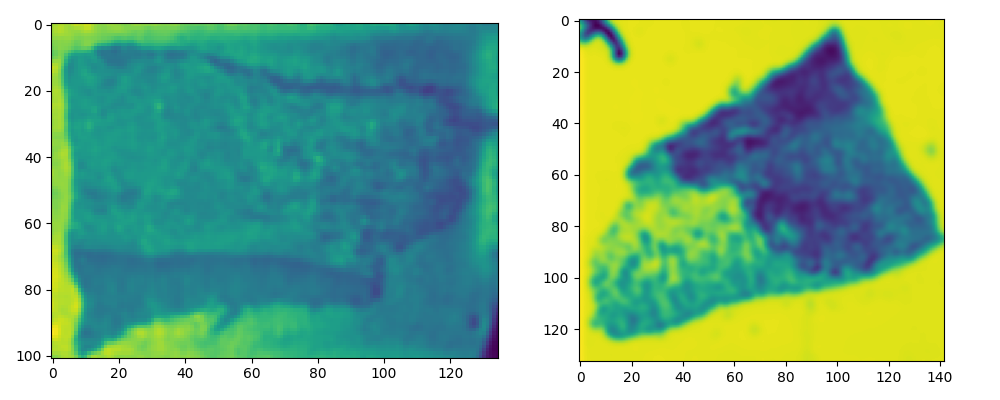

In [95]:
%matplotlib widget
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

step_mod1 = 4
ax = axs[0]
ax.imshow(gaussian_filter(modality1[::step_mod1, ::step_mod1], sigma = 0.5))

step_mod2 = 8
ax = axs[1]
ax.imshow(gaussian_filter(modality2[::step_mod2, ::step_mod2]), sigma = 0.5)

fig.tight_layout()

## 1.3 Align

In [315]:
mod1 = gaussian_filter(modality1[::step_mod1, ::step_mod1], sigma = 0.5)
mod2 = gaussian_filter(modality2[::step_mod2, ::step_mod2], sigma = 0.5)

In [328]:
device = 'cuda' #'cuda' if torch.cuda.is_available() else 'cpu'
# rot_angle_range = np.linspace(0, 3*np.pi/2, 4)

best_params, mode = optimize_affine_transform_pytorch(mod1, 
                                                    mod2, 
                                                    device = device, 
                                                    lr = 1e-2, 
                                                    mom = 0.8, 
                                                    num_iters = 800, 
                                                    scale_norm = 0,
                                                    norm_mi = False)
print(best_params)

{'rot_angle': 2.799999952316284, 'translate': [-0.12999999523162842, 0.029999999329447746], 'scale_x': 0.9599999785423279, 'scale_y': 0.8399999737739563}


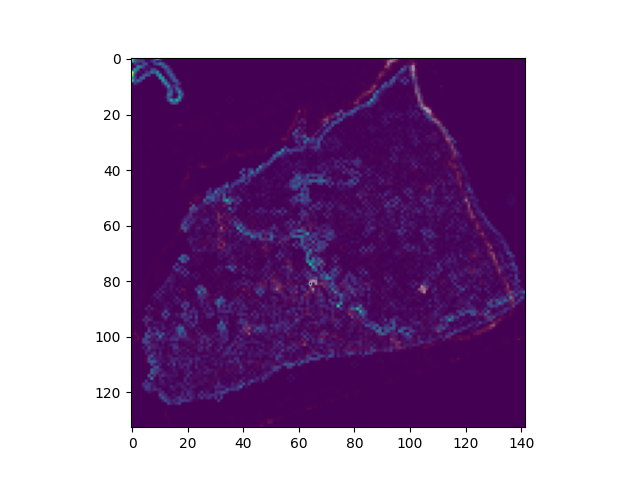

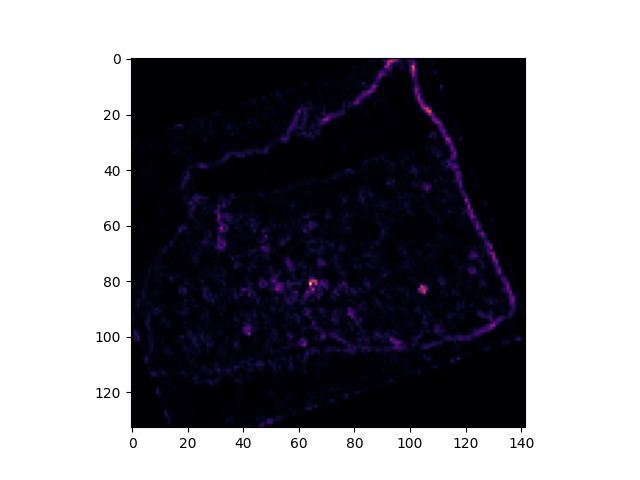

In [329]:
scalex = best_params['scale_x']
scaley = best_params['scale_y']

angle = best_params['rot_angle']
tx = best_params['translate'][0]
ty = best_params['translate'][1]

# scalex = 1.08
# scaley = 1.03
# angle =np.pi - 0.44
# tx = -0.3
# ty = -0.08

affine_final = AffineTransform(scalex, scaley, tx, ty, angle)
transformed_image = affine_final(torch.tensor(mod1_grad).float().unsqueeze(0).unsqueeze(0), 
                                 torch.tensor(mod2).float().unsqueeze(0).unsqueeze(0).size()).squeeze(0).squeeze(0).detach().numpy()

from matplotlib.colors import ListedColormap

cmap = plt.cm.RdBu
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:, -1] = np.linspace(0, 1, cmap.N)
my_cmap = ListedColormap(my_cmap)

plt.figure()
plt.imshow(mod2_grad)
plt.imshow(transformed_image, cmap = my_cmap)

plt.figure()
plt.imshow(transformed_image, cmap = 'inferno', alpha = 1)

In [131]:
mutual_info = MI(dimension = 2, num_bins = 10, kernel_sigma = 0.2, normalized = True)
-mutual_info.mi(torch.tensor(transformed_image).float().unsqueeze(0).unsqueeze(0),
               torch.tensor(mod2).float().unsqueeze(0).unsqueeze(0))

tensor(-1.1274)

In [539]:
metric = MultiModalAlignmentMetric()
-metric(torch.tensor(transformed_image).float().unsqueeze(0).unsqueeze(0),
       torch.tensor(mod2).float().unsqueeze(0).unsqueeze(0))

tensor(-0.1011)